<a href="https://colab.research.google.com/github/Patience3/cinic10-image-classifier-cnn/blob/main/Convulutional_Neural_Network_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ================================================================
## 1.Preparing data to load from Kaggle
# ================================================================

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [2]:
import os
import zipfile

data_dir = "./cinic10"
dataset = "mengcius/cinic10"
archive_path = os.path.join(data_dir, "cinic10.zip")

# Clean start every run
if os.path.exists(data_dir):
    !rm -rf {data_dir}
os.makedirs(data_dir, exist_ok=True)

# Download and unzip
!kaggle datasets download -d {dataset} -p {data_dir}

with zipfile.ZipFile(archive_path, 'r') as zip_ref:
    zip_ref.extractall(data_dir)

print("Data ready at:", data_dir)


Dataset URL: https://www.kaggle.com/datasets/mengcius/cinic10
License(s): unknown
 94% 707M/754M [00:03<00:00, 161MB/s]
100% 754M/754M [00:03<00:00, 221MB/s]
Data ready at: ./cinic10


## 2. Importing dependencies

In [4]:
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Available device:", device)





Available device: cuda


================================================================
## 3. Load Dataset
# ================================================================


In [5]:
IMG_SIZE = 32
BATCH_SIZE = 128

# Training transforms (augmentation + normalization)
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(IMG_SIZE, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4789, 0.4723, 0.4305],
                         std=[0.2421, 0.2383, 0.2587])
])

# Validation / Test transforms (only resize + normalize, no augmentation)
test_val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4789, 0.4723, 0.4305],
                         std=[0.2421, 0.2383, 0.2587])
])

train_dir = os.path.join(data_dir, "train")
test_dir  = os.path.join(data_dir, "test")
val_dir   = os.path.join(data_dir, "valid")

train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
test_dataset  = datasets.ImageFolder(test_dir, transform=test_val_transform)
val_dataset   = datasets.ImageFolder(val_dir, transform=test_val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("Train samples:", len(train_dataset))
print("Test samples:", len(test_dataset))
print("Validation samples:", len(val_dataset))

classes = train_dataset.classes
print(classes)


Train samples: 90000
Test samples: 90000
Validation samples: 90000
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [6]:
images, labels = next(iter(train_loader))
print(images.shape, labels[:10])


torch.Size([128, 3, 32, 32]) tensor([1, 5, 5, 2, 6, 2, 6, 6, 8, 4])


# ================================================================
### 4. Visualize Sample Images
# ================================================================


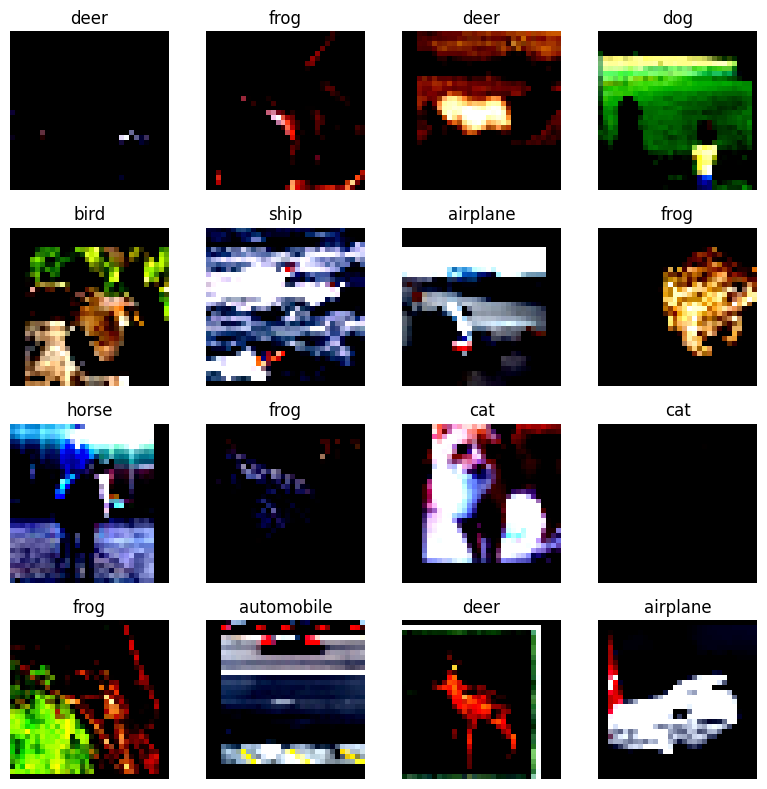

In [7]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

plt.figure(figsize=(8, 8))
for i in range(16):
    plt.subplot(4, 4, i+1)
    img = images[i].permute(1, 2, 0).numpy()
    plt.imshow(img)
    plt.axis('off')
    plt.title(classes[labels[i]])
plt.tight_layout()
plt.show()

# ================================================================
### 5. CNN defined
# =======================================================

CNNs deal with spatial features. The raw activations after convolutions can vary a lot in scale. BatchNorm keeps them in a stable range, which makes training converge faster.
It reduces sensitivity to initialization and learning rate. Without BatchNorm, you often have to be very careful with these.
It acts as a regularizer. So you can often rely less on Dropout, or even skip it altogether.

In [8]:


class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3   = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Dropout after conv layers (light)
        self.dropout_conv = nn.Dropout(0.25)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 256)   # 32x32 → 16x16 → 8x8 → 4x4
        self.relu_fc1 = nn.ReLU()
        self.dropout_fc = nn.Dropout(0.5)        # heavier dropout before final layer
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        # Conv layers with dropout
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu3(self.bn3(self.conv3(x))))
        x = self.dropout_conv(x)

        # Flatten
        x = x.view(x.size(0), -1)

        # Fully connected layers with dropout
        x = self.relu_fc1(self.fc1(x))
        x = self.dropout_fc(x)
        x = self.fc2(x)
        return x



# Instantiate model
num_classes = len(classes)
cnn_model = SimpleCNN(num_classes=num_classes).to(device)
print(cnn_model)

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout_conv): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (relu_fc1): ReLU()
  (dropout_fc): Dropout(p=0.5, inplace=False)

# ================================================================
### 6. Loss Function and Optimizer
# ================================================================


In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001, weight_decay=1e-4)



# ================================================================
### 7. Training Loop
# ================================================================


In [10]:
num_epochs = 35
patience = 3   # number of epochs to wait before stopping if no improvement
best_val_loss = float("inf")
epochs_no_improve = 0

train_losses, val_losses, train_acc, val_acc = [], [], [], []

for epoch in range(num_epochs):
    cnn_model.train()
    running_loss, train_correct, train_total = 0.0, 0, 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = cnn_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * y_batch.size(0)
        _, predicted = outputs.max(1)
        train_total += y_batch.size(0)
        train_correct += predicted.eq(y_batch).sum().item()

    epoch_loss = running_loss / train_total
    epoch_acc = 100.0 * train_correct / train_total
    train_losses.append(epoch_loss)
    train_acc.append(epoch_acc)

    # Validation
    cnn_model.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = cnn_model(X_batch)
            loss = criterion(outputs, y_batch)
            val_running_loss += loss.item() * y_batch.size(0)
            _, predicted = outputs.max(1)
            val_total += y_batch.size(0)
            val_correct += predicted.eq(y_batch).sum().item()

    val_loss = val_running_loss / val_total
    val_accuracy = 100.0 * val_correct / val_total
    val_losses.append(val_loss)
    val_acc.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}% "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

    # --- Early Stopping Logic ---
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(cnn_model.state_dict(), "best_model.pth")  # save the best model
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

# Load best model after training
cnn_model.load_state_dict(torch.load("best_model.pth"))


Epoch [1/35] Train Loss: 1.6533, Train Acc: 37.92% Val Loss: 1.3630, Val Acc: 49.33%
Epoch [2/35] Train Loss: 1.4438, Train Acc: 46.61% Val Loss: 1.3010, Val Acc: 51.65%
Epoch [3/35] Train Loss: 1.3626, Train Acc: 50.18% Val Loss: 1.1876, Val Acc: 56.74%
Epoch [4/35] Train Loss: 1.3102, Train Acc: 52.43% Val Loss: 1.1366, Val Acc: 58.24%
Epoch [5/35] Train Loss: 1.2677, Train Acc: 54.28% Val Loss: 1.1938, Val Acc: 57.48%
Epoch [6/35] Train Loss: 1.2296, Train Acc: 55.78% Val Loss: 1.0729, Val Acc: 61.15%
Epoch [7/35] Train Loss: 1.2060, Train Acc: 56.77% Val Loss: 1.0426, Val Acc: 62.32%
Epoch [8/35] Train Loss: 1.1764, Train Acc: 57.87% Val Loss: 1.0498, Val Acc: 62.40%
Epoch [9/35] Train Loss: 1.1521, Train Acc: 58.71% Val Loss: 1.0585, Val Acc: 62.10%
Epoch [10/35] Train Loss: 1.1254, Train Acc: 59.79% Val Loss: 0.9816, Val Acc: 64.65%
Epoch [11/35] Train Loss: 1.1113, Train Acc: 60.34% Val Loss: 0.9664, Val Acc: 64.96%
Epoch [12/35] Train Loss: 1.0857, Train Acc: 61.16% Val Loss: 0

<All keys matched successfully>

# ================================================================
### 8. Plot Training and Validation Curves
# ================================================================


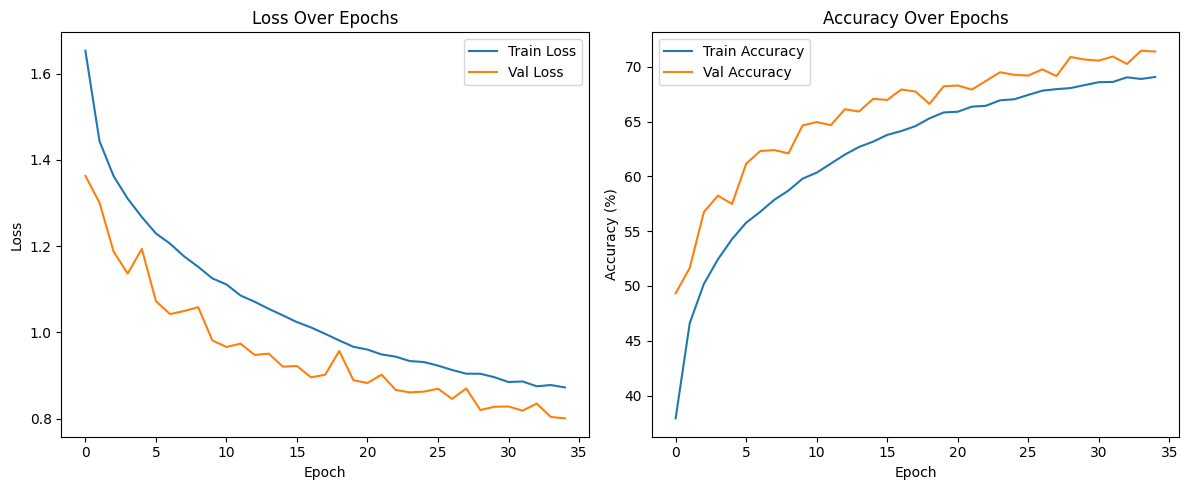

In [11]:
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Over Epochs")
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, label="Train Accuracy")
plt.plot(val_acc, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Over Epochs")
plt.legend()

plt.tight_layout()
plt.show()


# ================================================================
### 9. Evaluate on Test Set
# ================================================================


              precision    recall  f1-score   support

    airplane       0.80      0.81      0.80      9000
  automobile       0.76      0.77      0.77      9000
        bird       0.71      0.65      0.68      9000
         cat       0.55      0.61      0.58      9000
        deer       0.72      0.55      0.62      9000
         dog       0.59      0.55      0.57      9000
        frog       0.81      0.80      0.80      9000
       horse       0.72      0.81      0.76      9000
        ship       0.74      0.82      0.78      9000
       truck       0.74      0.74      0.74      9000

    accuracy                           0.71     90000
   macro avg       0.71      0.71      0.71     90000
weighted avg       0.71      0.71      0.71     90000



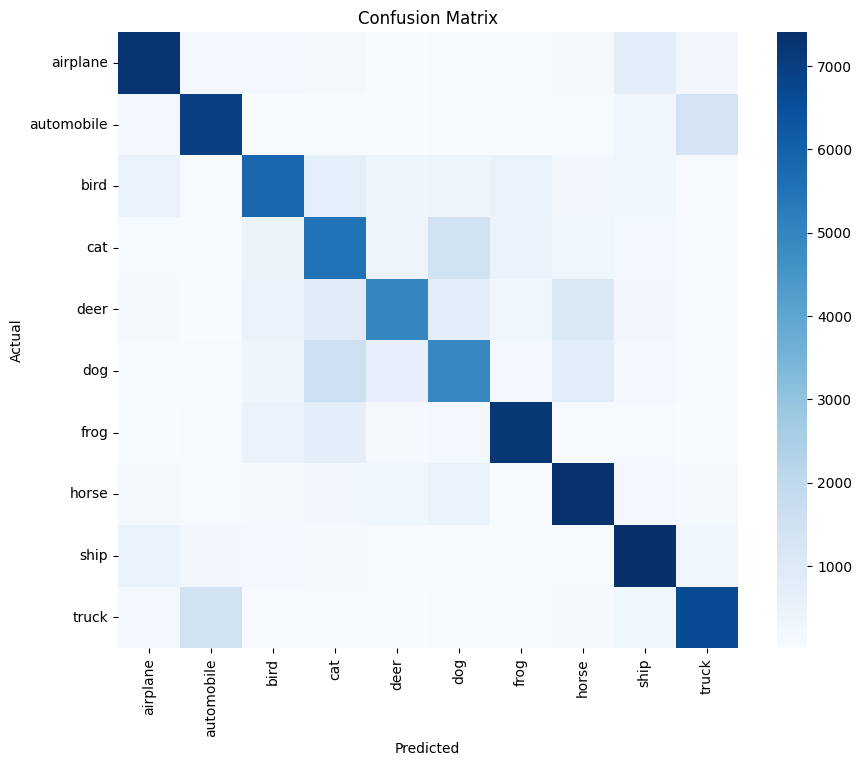

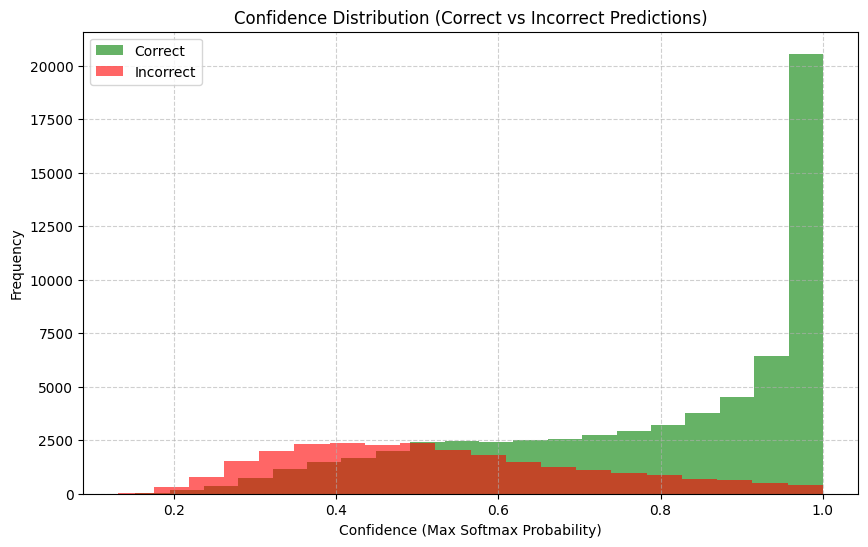

In [12]:

cnn_model.eval()
all_preds, all_labels = [], []
confidences, correctness = [], []   # <-- add these

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = cnn_model(X_batch)

        # predictions
        probs = torch.softmax(outputs, dim=1)          # <-- add softmax
        max_probs, preds = probs.max(1)                # <-- add confidence

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

        # store for analysis
        confidences.extend(max_probs.cpu().numpy())
        correctness.extend(preds.eq(y_batch).cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=classes))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ================================================================
### Confidence Analysis
# ================================================================

confidences = np.array(confidences)
correctness = np.array(correctness)

plt.figure(figsize=(10, 6))
plt.hist(confidences[correctness == 1], bins=20, alpha=0.6, label="Correct", color="green")
plt.hist(confidences[correctness == 0], bins=20, alpha=0.6, label="Incorrect", color="red")
plt.xlabel("Confidence (Max Softmax Probability)")
plt.ylabel("Frequency")
plt.title("Confidence Distribution (Correct vs Incorrect Predictions)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


  Displaying some images, to visually appreciate model progreaa

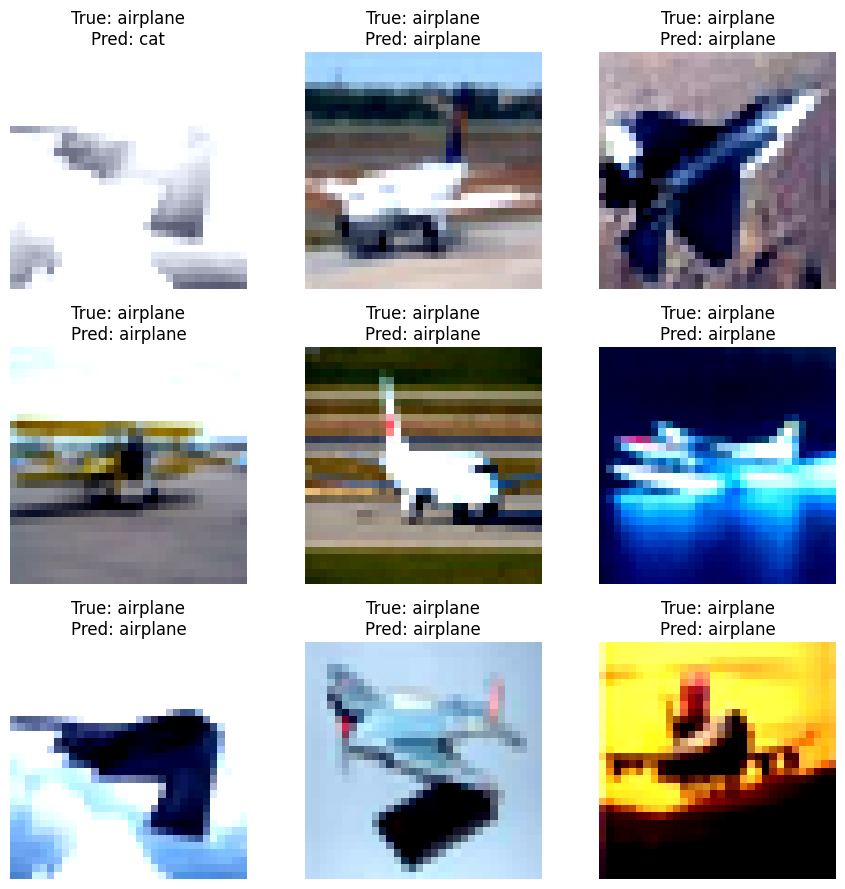

In [13]:
import random

# Get a batch from validation
data_iter = iter(val_loader)
images, labels = next(data_iter)

images, labels = images.to(device), labels.to(device)
outputs = cnn_model(images)
_, preds = torch.max(outputs, 1)

# Show a few
fig, axes = plt.subplots(3, 3, figsize=(9, 9))
for i, ax in enumerate(axes.flat):
    # Pick an index
    idx = random.randint(0, len(images) - 1)
    img = images[idx].cpu().permute(1, 2, 0).numpy()  # CHW → HWC for matplotlib
    img = (img * 0.5 + 0.5).clip(0, 1)  # unnormalize if you normalized [-1,1]

    true_label = classes[labels[idx].item()]
    pred_label = classes[preds[idx].item()]

    ax.imshow(img)
    ax.set_title(f"True: {true_label}\nPred: {pred_label}")
    ax.axis("off")

plt.tight_layout()
plt.show()


# ================================================================
### 10. Save and Load Model
# ================================================================


In [15]:

# Save
torch.save(cnn_model.state_dict(), "cnn_model.pth")
print("model saved.")

# Reload
reloaded_model = SimpleCNN(num_classes=num_classes).to(device)
reloaded_model.load_state_dict(torch.load("cnn_model.pth"))
reloaded_model.eval()
print("model reloaded and ready.")


model saved.
model reloaded and ready.


# ================================================================
### 11. Prediction with Unknown Handling
# ================================================================


In [16]:
def predict_with_unknown(model, image, classes, threshold=0.6):
    model.eval()
    with torch.no_grad():
        outputs = model(image.unsqueeze(0).to(device))
        probs = torch.softmax(outputs, dim=1)
        max_prob, pred_class = torch.max(probs, 1)

        if max_prob.item() < threshold:
            return "Unknown", max_prob.item()
        else:
            return classes[pred_class.item()], max_prob.item()
